In [1]:
import pathlib
nb_dir = pathlib.Path.cwd()
output_dir =   nb_dir.joinpath("out")
# Create output directory if it does not exist
if not output_dir.exists():
    os.makedirs(output_dir)

In [2]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [3]:
import helper_tutorials

<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 50%;">
   

In [4]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate = False)

ℹ️ Using TEST LICENSE (expires December 8, 2025 - 34 days remaining)
   For production use, obtain your own license from Tech Soft 3D


# View your cad model in the notebook

In [5]:
cad_filename = nb_dir.parent.joinpath("packages", "cadfiles", "pn_verschr_r1.prt.1")
from hoops_ai.insights import CADViewer
viewer = CADViewer(static_folder=output_dir)
viewer.load_cad_file(cad_filename)

True

In [6]:
viewer.show()
status = viewer.get_status()
print(f"Viewer is running on port: {status['port']}")
print(f"Viewer URL: {status['viewer_url']}")

Viewer is running on port: 8001
Viewer URL: http://127.0.0.1:8001


# HOOPS AI: Encoder Module

## BrepEncoder

The `BrepEncoder` class is responsible for computing and persisting geometry and topology data from a B-rep. It provides methods (called "push" methods) that extract specific features from the model and if the DataStorage object is provided, it can storage it in a compressed optimal file. Very handy when working with large datasets. 

## Initialize the HOOPSLoader and set the BRep options

In [7]:
from hoops_ai.cadaccess import HOOPSLoader, HOOPSModel, HOOPSTools

In [8]:
# open the cad file
cad_loader =  HOOPSLoader()
cad_model = cad_loader.create_from_file(str(cad_filename))

# Adapt to extract BRep information
hoopstools  = HOOPSTools()
hoopstools.adapt_brep(cad_model)



# BRep data as numerical features for ML

In [9]:
from hoops_ai.cadencoder import BrepEncoder

brep_encoder = BrepEncoder(cad_model.get_brep())
#brep_encoder = BrepEncoder(cad_model.get_brep(), storage=writeStorage)

## Encoding the Topology

##### `push_face_adjacency_graph() -> nx.Graph`

Builds and stores a face adjacency graph from the B-rep model. This graph represents the topology of the model where nodes are faces and edges connect adjacent faces.


In [10]:
adj_graph = brep_encoder.push_face_adjacency_graph()

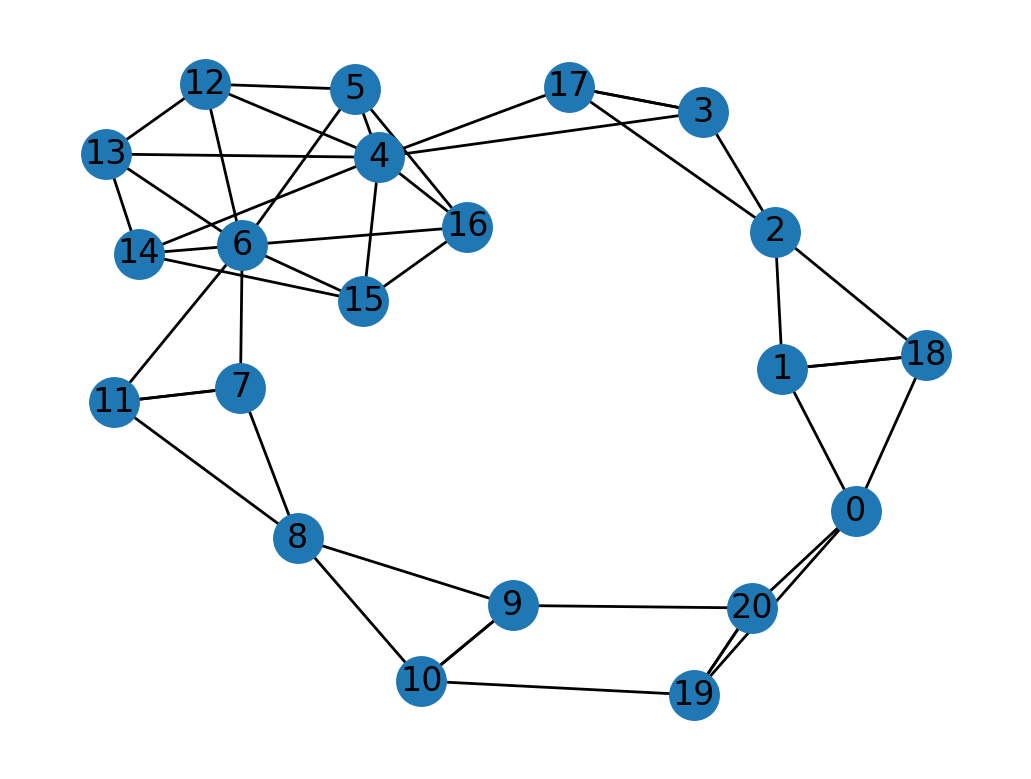

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(adj_graph)
nx.draw_networkx(adj_graph, pos, arrows=False)   # draw nodes, edges, labels
plt.axis('off')                         # turn off axes for clarity
plt.show()

In [12]:
face_index = 9
neighbor_faces = set(adj_graph.successors(face_index)) | set(adj_graph.predecessors(face_index))

print(neighbor_faces)

{8, 10, 20}


In [20]:
viewer.set_face_color([9], [255,0,0])

In [14]:
viewer.set_face_color(neighbor_faces, [155,155,0])

In [22]:
viewer.clear_face_colors()

In [23]:
# INTERACTIVE Get the face indices you selected interactively
selected_faces = viewer.get_selected_faces()

print(f"You selected {len(selected_faces)} faces: {selected_faces}")

You selected 2 faces: [15, 10]


In [24]:
# Highlight selected faces with a custom green color
viewer.set_face_color(selected_faces, [150, 255, 100])

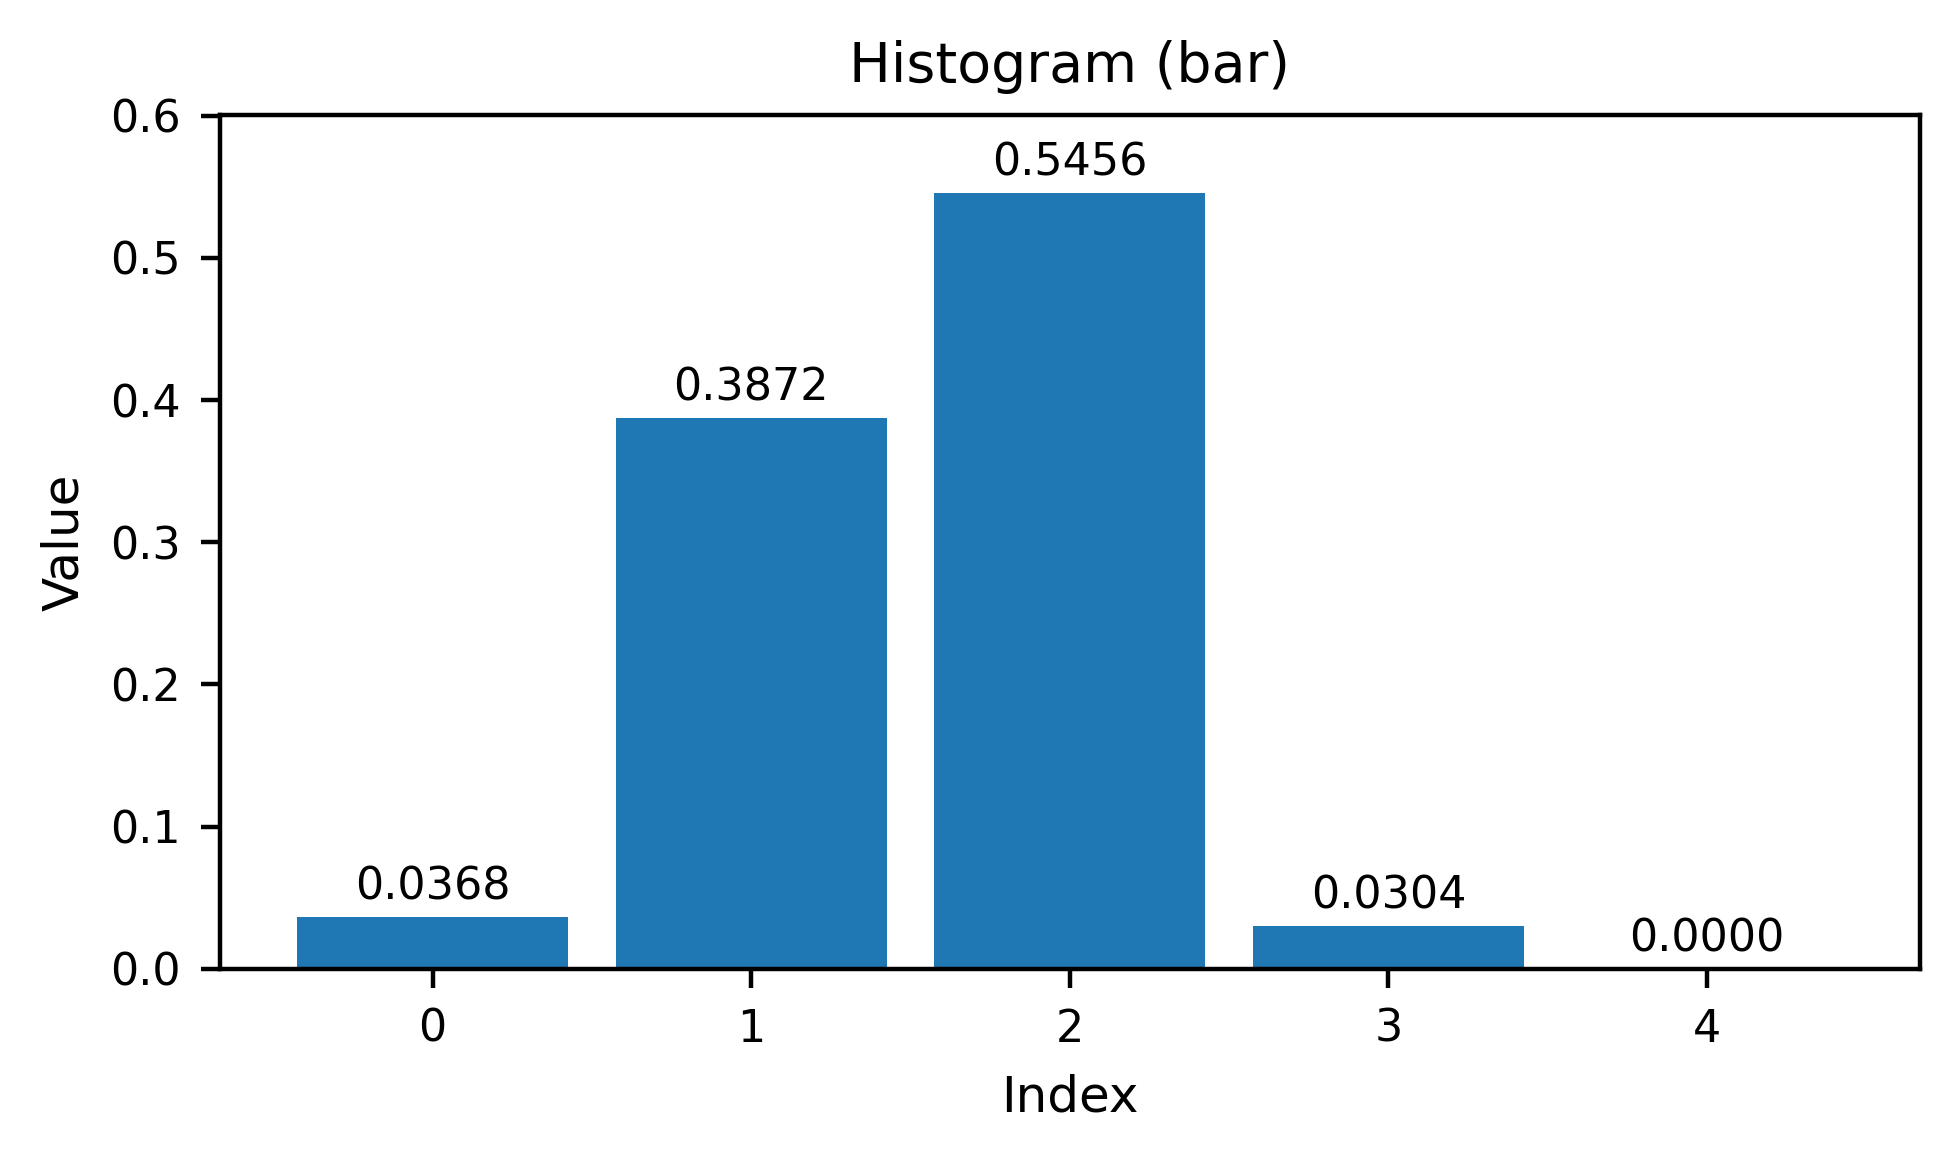

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Histogram (bar)'}, xlabel='Index', ylabel='Value'>)

In [27]:
avg_distance = brep_encoder.push_average_face_pair_distance_histograms(10,5)
helper_tutorials.plot_bar(avg_distance[15,10])

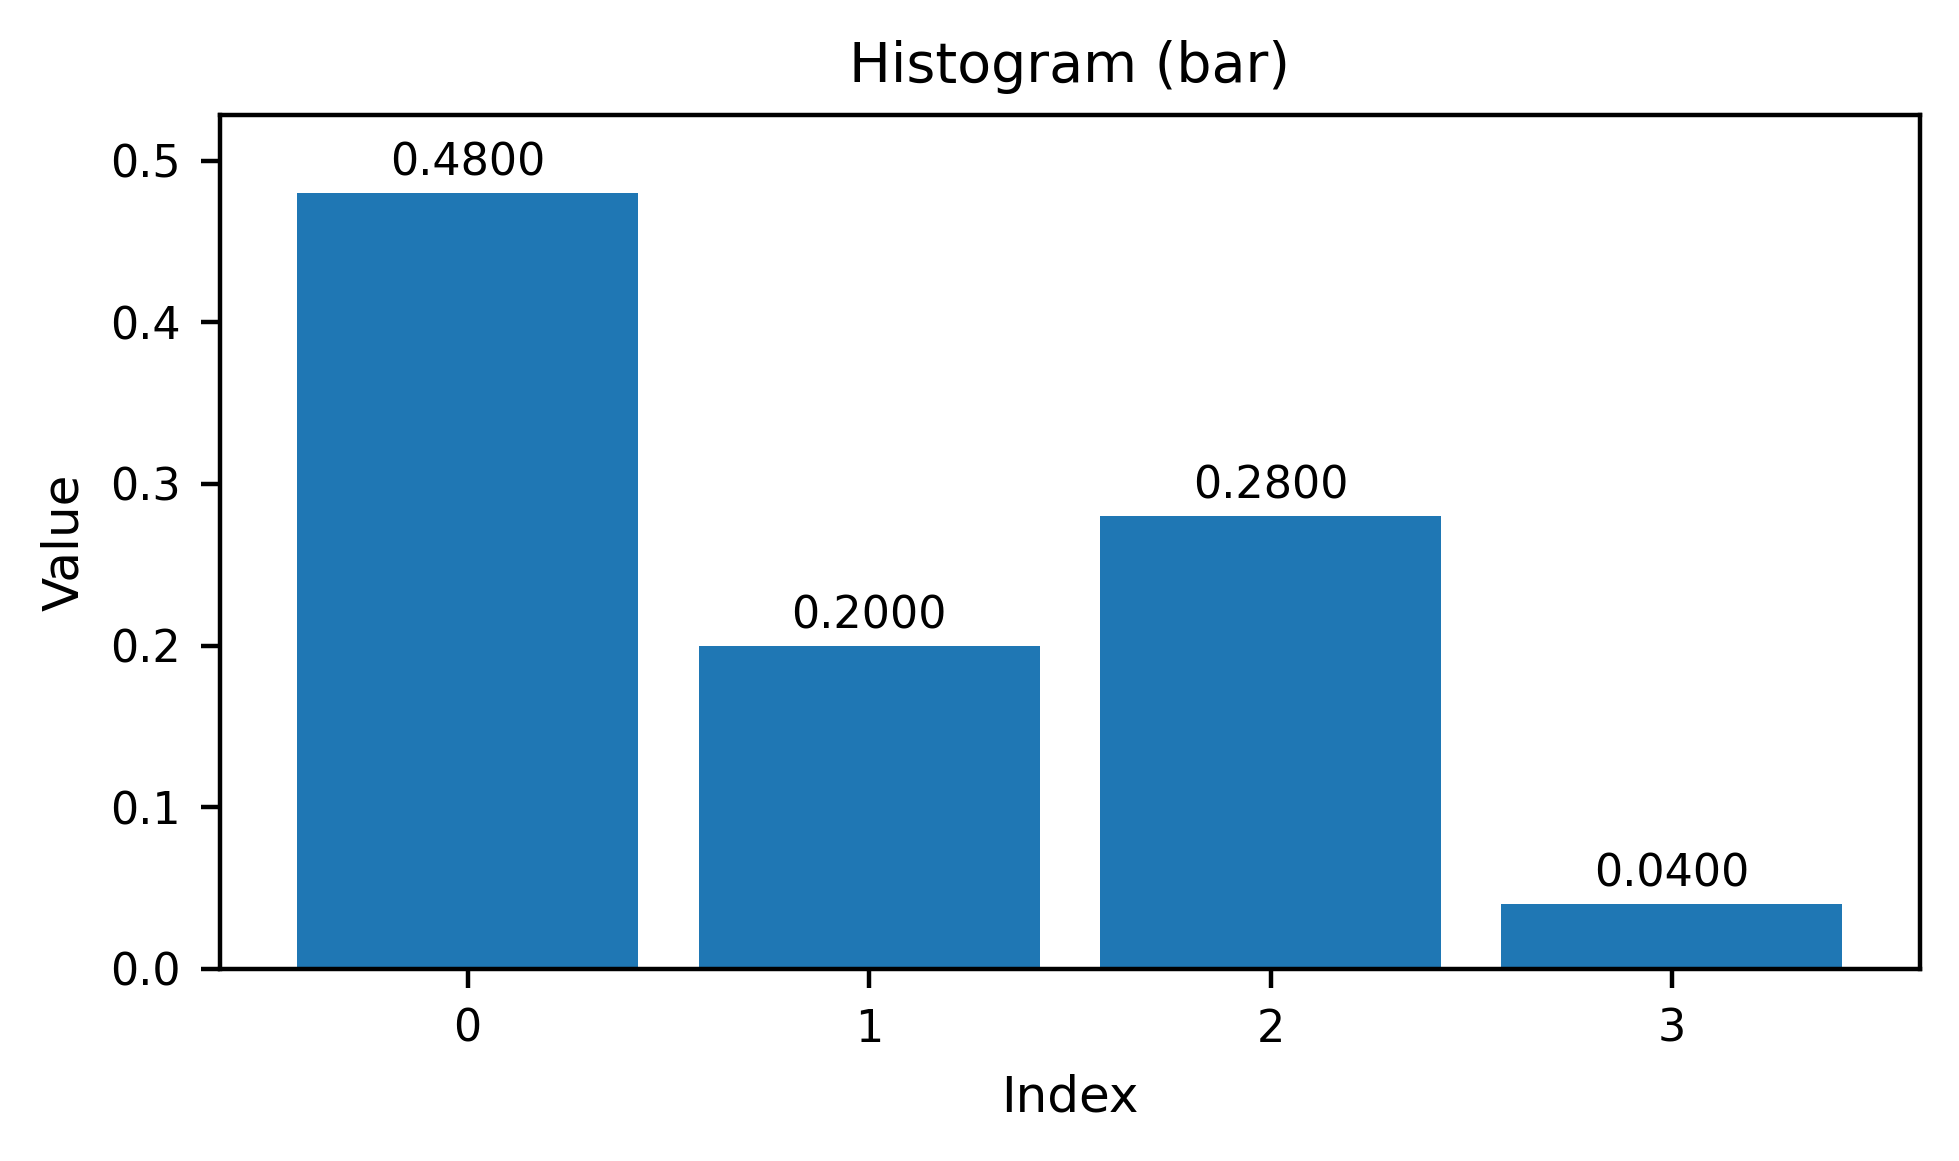

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Histogram (bar)'}, xlabel='Index', ylabel='Value'>)

In [29]:
avg_angles = brep_encoder.push_average_face_pair_angle_histograms(10,4)
helper_tutorials.plot_bar(avg_angles[15,10])

# Encoding the Geometry

##### `push_face_discretization(pointsamples: int = 25) -> np.ndarray`

Samples points, normals, and inside/outside information on a discretized grid across each face.

In [30]:
face_discretization = brep_encoder.push_face_discretization(pointsamples=24)  # 16 sample points per face
print("face_discretization\n", face_discretization.shape)

face_discretization
 (21, 24, 7)


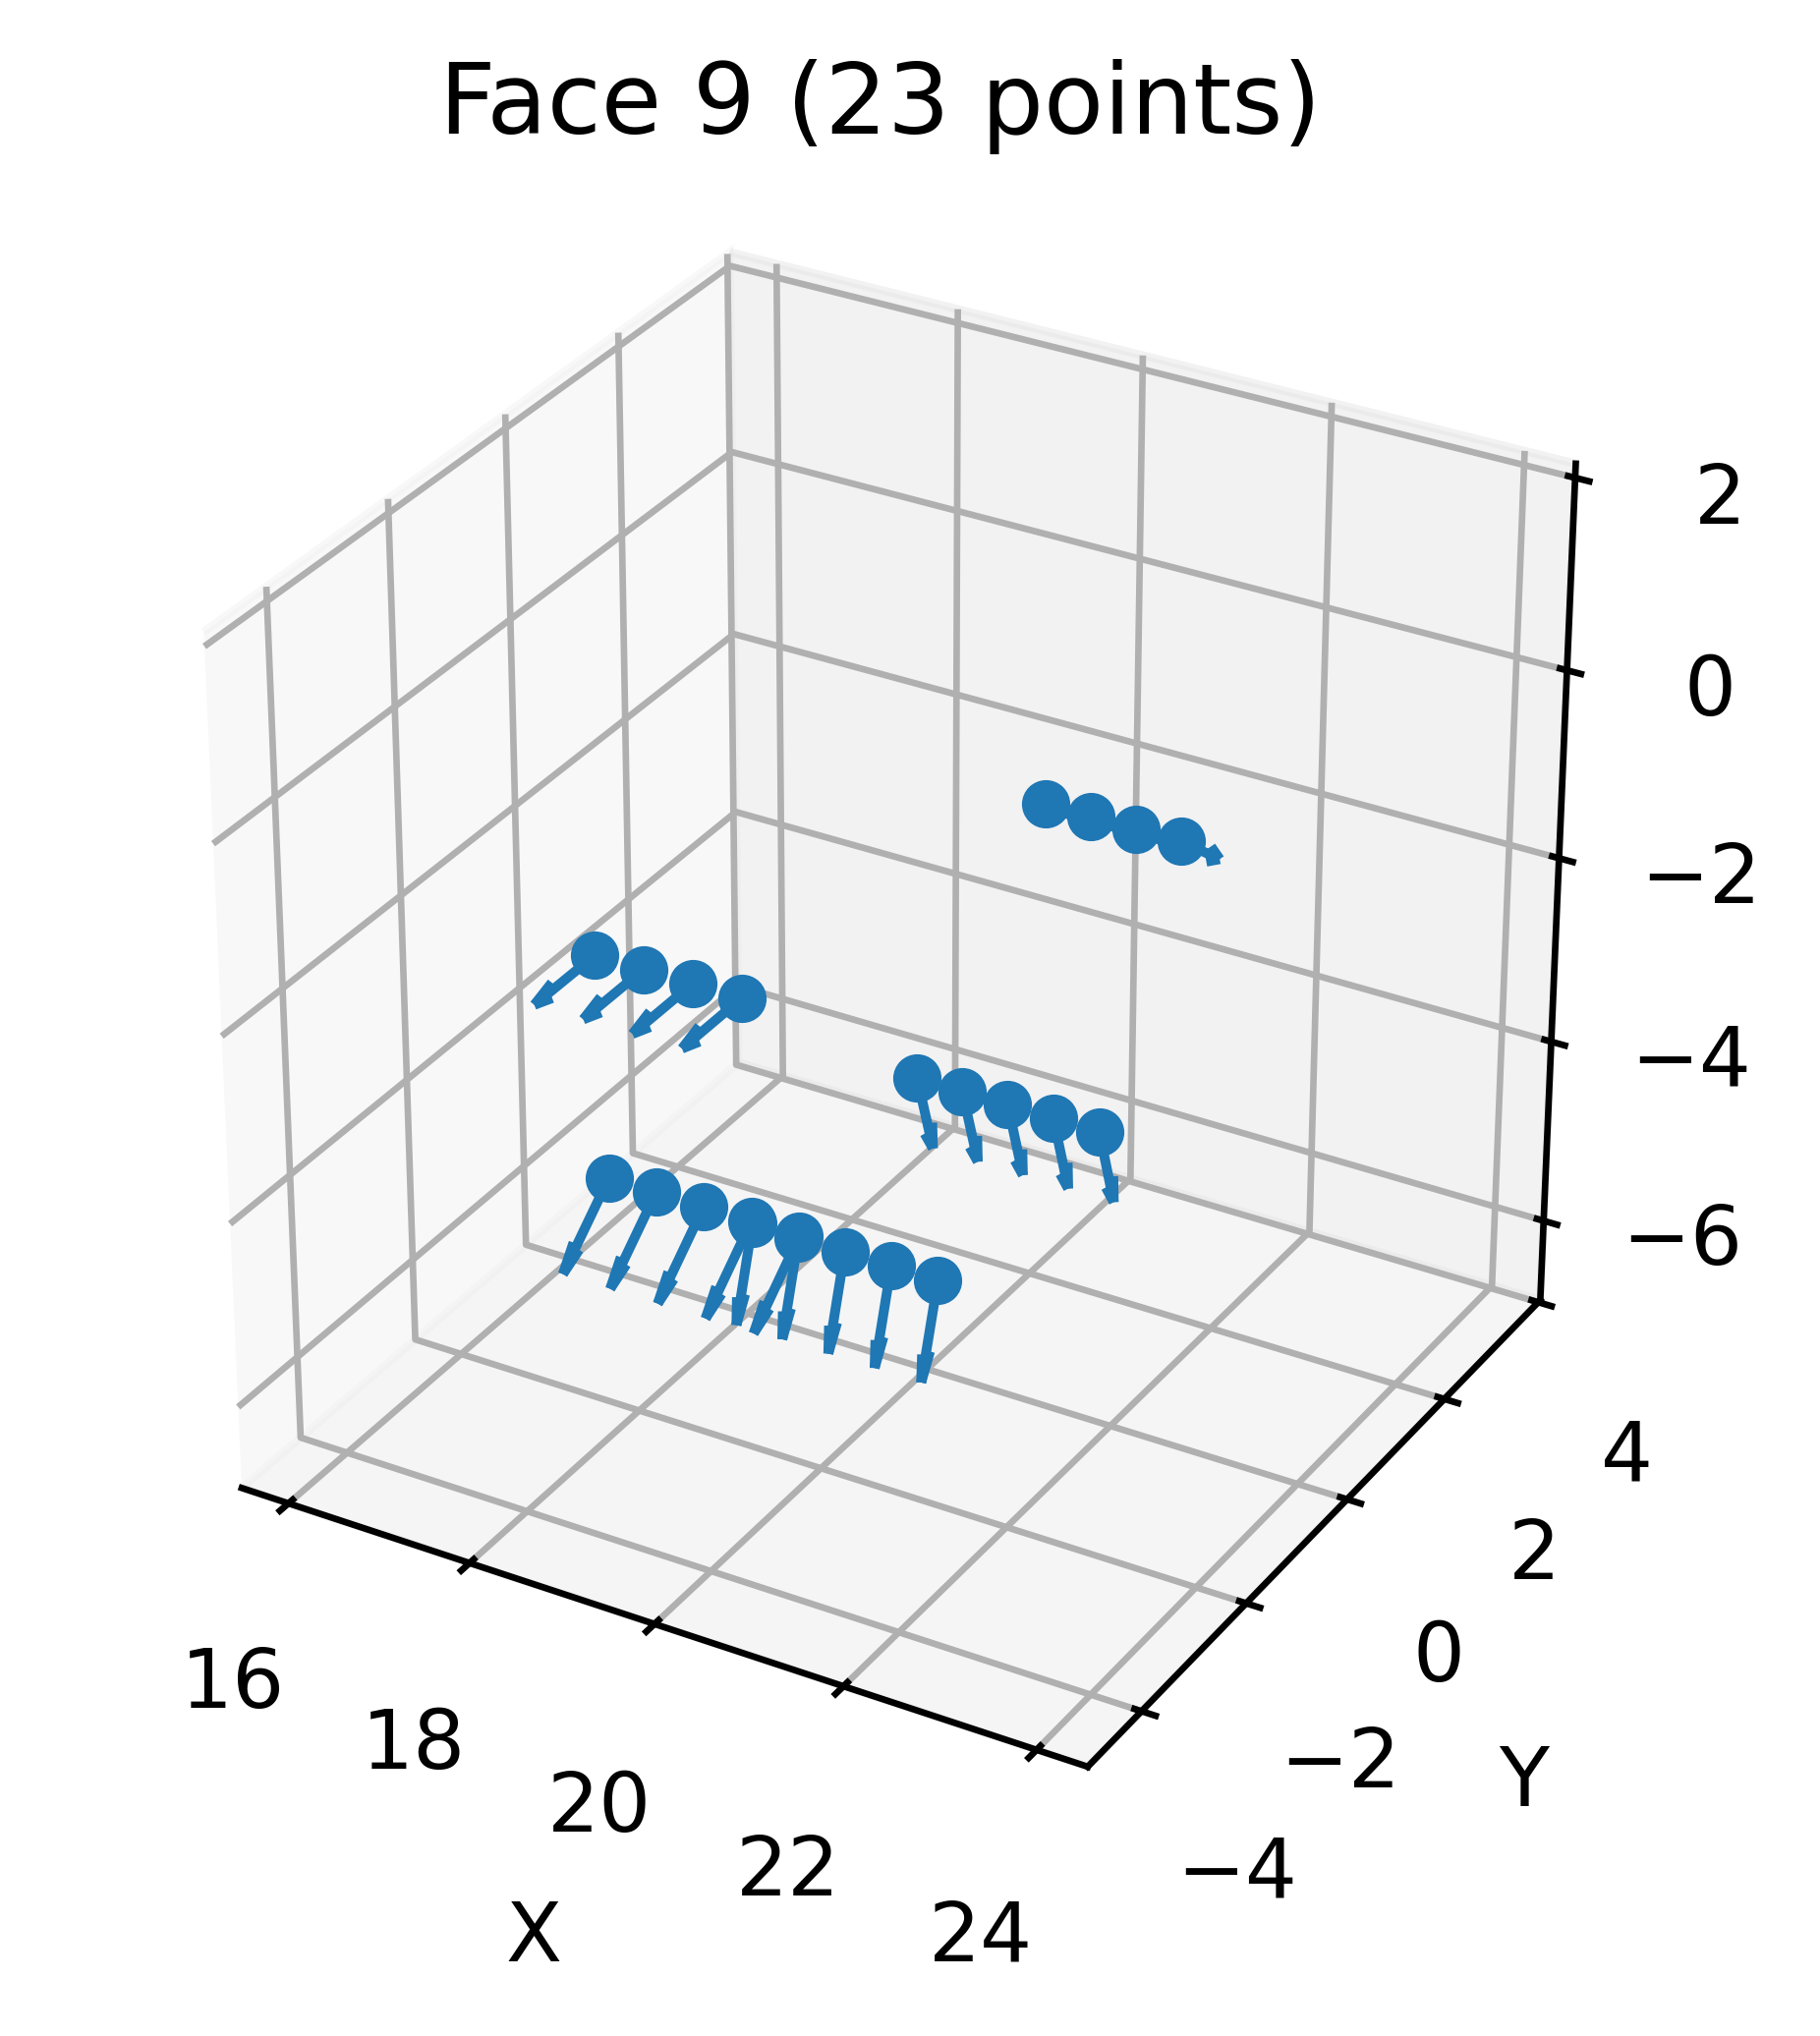

(<Figure size 1200x900 with 1 Axes>,
 <Axes3D: title={'center': 'Face 9 (23 points)'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [33]:
#viewer.clear_face_colors()
use_face_index = 9

viewer.set_face_color([use_face_index])
helper_tutorials.plot_face_points(face_discretization, face_idx=use_face_index, show_normals=True, connect=False)

##### `push_curvegrid(ugrid: int = 5) -> np.ndarray`

Samples points along edges at regular intervals.

- **Parameters**:
  - `ugrid`: Number of sample points along each edge (default: 5)
- **Returns**: 0 on success
- **Storage Format**: edgecountÃ—ugridÃ—feature_dim numpy array of sampled data

In [34]:
edge_discretization = brep_encoder.push_curvegrid(5)
print("edge_discretization\n", edge_discretization.shape)

edge_discretization
 (46, 5, 6)


##### `push_face_attributes() -> int`

Extracts and stores various face attributes, including face types, areas, and loop counts.

# Encoding the attributes 

In [35]:
[face_types, face_areas, face_loops], face_types_descr = brep_encoder.push_face_attributes()
print("face_types", face_types)
print("face_areas", face_areas)
print("face_loops", face_loops)
print("face_types_descr", face_types_descr)

face_types [0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 2 2]
face_areas [ 43.911655 141.3149    75.277115  51.831074  24.732485  57.030937
  19.963306  12.871587  28.228918  39.265965  39.265965  12.871587
  57.030937  57.030933  57.030937  57.030937  57.030933  51.831074
 141.3149    10.575602  10.575602]
face_loops [2 1 2 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1]
face_types_descr {0: 'Plane', 1: 'Cylinder', 2: 'Cone'}


##### `push_edge_attributes() -> List[ndarray], Dict`

Extracts and stores various edge attributes, including edge types, lengths, dihedral angles, and convexities.

- **Storage Keys**: "edge_types", "edge_lengths", "edge_dihedral_angles", "edge_convexities", and metadata "descriptions/edge_types"
- **Storage Format**: 1D numpy arrays for each attribute type

In [36]:
[edge_types_np, edge_lengths_np, edge_dihedrals_np, edge_convexities_np], edge_type_descrip = brep_encoder.push_edge_attributes()
print("edge_types_np", edge_types_np)
print("edge_lengths_np", edge_lengths_np)
print("edge_dihedrals_np", edge_dihedrals_np)
print("edge_convexities_np", edge_convexities_np)
print("edge_type_descrip", edge_type_descrip)

edge_types_np [1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0
 0 1 1 0 0 0 0 0 0]
edge_lengths_np [14.137167   14.137167    7.8539815   7.8539815  18.          7.8539815
 18.         17.278759   17.278759    7.8539815   3.          3.
 17.278759   17.278759    5.196152    5.196152    5.196152    5.196152
  5.196152    5.196152   10.97561     5.196152   10.97561     5.196152
  5.196152    5.196152    5.196152    5.196152   12.566371   12.566371
  1.0243902  12.566371    1.0243902  15.707963   15.707963   12.566371
  2.5         2.5        15.707963   15.707963   10.97561    10.97561
 10.97561    10.97561     0.70710677  0.70710677]
edge_dihedrals_np [ 7.8539819e-01  7.8539819e-01 -1.5707964e+00 -1.5707964e+00
  2.4492937e-16  1.5707964e+00  0.0000000e+00 -1.5707964e+00
 -1.5707964e+00  1.5707964e+00  0.0000000e+00  2.4492937e-16
  1.5707964e+00  1.5707964e+00 -1.5707964e+00 -1.5707964e+00
 -1.5707964e+00 -1.5707964e+00 -1.5707964e+00 -1.5707964e+00
  1.0471976

In [ ]:
viewer.terminate()